In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

In [2]:
raw_data_path = "Purchase_Card_Transactions.csv"
raw_data = pd.read_csv(raw_data_path)
# raw_data["TRANSACTION_DATE"] = pd.to_datetime(raw_data["TRANSACTION_DATE"])
raw_data = raw_data.applymap(lambda s:s.upper() if type(s) == str else s)
raw_data = raw_data.applymap(lambda s:re.sub("[^\w]", "_", s) if type(s) == str else s)

In [3]:
raw_data.head()

,OBJECTID,AGENCY,TRANSACTION_DATE,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION
0,64,DEPARTMENT_OF_HEALTH,2009_01_06_05_00_00_00,4.75,NPDB_NPDB_HIPDB_HRSA_G,VA,GOVERNMENT_SERVICES__NOT_ELSEWHERE_CLASSIFIED
1,65,DEPARTMENT_OF_HEALTH,2009_01_06_05_00_00_00,-464.48,PRESSTEK,NH,COMMERCIAL_PHOTOGRAPHY__ART___GRAPHICS
2,66,DEPARTMENT_OF_HEALTH,2009_01_05_05_00_00_00,425.00,AMERICAN_ASSOC00_OF_00,VA,CHARITABLE_AND_SOCIAL_SERVICE_ORGANIZATIONS
3,67,DEPARTMENT_OF_HEALTH,2009_01_06_05_00_00_00,4.75,HIPDB_NPDB_HIPDB_HRSA_,VA,GOVERNMENT_SERVICES__NOT_ELSEWHERE_CLASSIFIED
4,68,DEPARTMENT_OF_HEALTH,2009_01_06_05_00_00_00,4.75,HIPDB_NPDB_HIPDB_HRSA_,VA,GOVERNMENT_SERVICES__NOT_ELSEWHERE_CLASSIFIED


In [4]:
# grouping

# split the data into multiple years
year_data = raw_data.drop(columns=["OBJECTID","TRANSACTION_DATE"])
year_data["YEAR"] = raw_data["TRANSACTION_DATE"].apply(lambda x: str(x)[:4])

year_data.head()

,AGENCY,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION,YEAR
0,DEPARTMENT_OF_HEALTH,4.75,NPDB_NPDB_HIPDB_HRSA_G,VA,GOVERNMENT_SERVICES__NOT_ELSEWHERE_CLASSIFIED,2009
1,DEPARTMENT_OF_HEALTH,-464.48,PRESSTEK,NH,COMMERCIAL_PHOTOGRAPHY__ART___GRAPHICS,2009
2,DEPARTMENT_OF_HEALTH,425.00,AMERICAN_ASSOC00_OF_00,VA,CHARITABLE_AND_SOCIAL_SERVICE_ORGANIZATIONS,2009
3,DEPARTMENT_OF_HEALTH,4.75,HIPDB_NPDB_HIPDB_HRSA_,VA,GOVERNMENT_SERVICES__NOT_ELSEWHERE_CLASSIFIED,2009
4,DEPARTMENT_OF_HEALTH,4.75,HIPDB_NPDB_HIPDB_HRSA_,VA,GOVERNMENT_SERVICES__NOT_ELSEWHERE_CLASSIFIED,2009


In [5]:
# grouping
grouped_data = year_data.groupby(["YEAR", "AGENCY", "VENDOR_NAME", "MCC_DESCRIPTION"], as_index=False).sum()
grouped_data["YEAR"].unique()

array(['2000', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020'], dtype=object)

In [6]:
# we have an outlier (year 2000), double check to see if there's any other outliers
year_data["YEAR"].unique()

array(['2009', '2010', '2011', '2000', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020'], dtype=object)

In [7]:
# Only one outlier, 2000, see what vendors and agencies are there
year_data[year_data["YEAR"]== "2000"]

,AGENCY,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION,YEAR
82171,DC_SENTENCING___CRIMINAL_CODE_REVIEW_COMMITTEE,-11.94,IMAGISTICS,CT,BUSINESS_SERVICES_NOT_ELSEWHERE_CLASSIFIED,2000


In [8]:
# Only one such transcation, let's remove it
year_data.drop(index=[82171], inplace=True)
# grouped_data.drop(index="2000", inplace=True)

In [9]:
def approximation(name):
    approx = "[^a-zA-Z]*"
    return "^"+ approx + name + approx + "$"

In [10]:
# years of interests
years = year_data["YEAR"].unique()
years

array(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020'], dtype=object)

In [11]:
# A metric for similarity
def measure_similarity(p1, p2, years, type_idx):
    similarity = {}
    type_names = ["AGENCY", "VENDOR_NAME"]
    p1 = approximation(p1)
    p2 = approximation(p2)

    type_name = type_names[type_idx] # either agency or vendor
    opp = type_names[(type_idx+1)%2] # if agency then vendor, vice versa

    # group based on mcc
    p1_df = grouped_data[grouped_data[type_name].str.match(p1, case=False)].groupby(["YEAR", "MCC_DESCRIPTION"], as_index=False).sum()
    p2_df = grouped_data[grouped_data[type_name].str.match(p2, case=False)].groupby(["YEAR", "MCC_DESCRIPTION"], as_index=False).sum()
    if p1_df.empty:
        print("can't find ventor/agency %s"%p1);
    if p2_df.empty:
        print("can't find ventor/agency %s"%21);
    # find their common mcc, its ratio, at each year
    for year in years:
        # slice out data of a year
        p1_year = p1_df[p1_df["YEAR"]==year]
        p2_year = p2_df[p2_df["YEAR"]==year]
        
        # calculate total transcation
        p1_transaction = p1_year["TRANSACTION_AMOUNT"].sum()
        p2_transaction = p2_year["TRANSACTION_AMOUNT"].sum()
        
        # if no transaction, then no similarity
        if (p1_transaction == 0) or (p2_transaction == 0):
            similarity[year] = 0
            continue
        total_transaction = p1_transaction + p2_transaction
        
        # find all the mccs
        p1_mccs = set(p1_year["MCC_DESCRIPTION"].unique())
        p2_mccs = set(p2_year["MCC_DESCRIPTION"].unique())
        
        # find the common mccs
        intersects = set.intersection(p1_mccs, p2_mccs)
#         print(intersects)
        # calculate the amount of transcations of common mccs
        common_transaction = 0
        for intersect in intersects:
            common_transaction += p1_year.loc[p1_df["MCC_DESCRIPTION"] == intersect, "TRANSACTION_AMOUNT"].sum()
            common_transaction += p2_year.loc[p2_df["MCC_DESCRIPTION"] == intersect, "TRANSACTION_AMOUNT"].sum()
        similarity[year] = common_transaction / total_transaction
    return similarity    

In [12]:
measure_similarity("ZOOM.US", "DELTA", years, 1)

{'2009': 0,
 '2010': 0,
 '2011': 0,
 '2012': 0,
 '2013': 0,
 '2014': 0,
 '2015': 0,
 '2016': 0,
 '2017': 0,
 '2018': 0.0,
 '2019': 0.0,
 '2020': 0.0}

In [13]:
measure_similarity("SPECIALTYBOOKS.COM", "AMAZON.COM", years, 1)

{'2009': 1.0,
 '2010': 1.0,
 '2011': 1.0,
 '2012': 0,
 '2013': 0,
 '2014': 0,
 '2015': 0,
 '2016': 0,
 '2017': 0,
 '2018': 0,
 '2019': 0,
 '2020': 0}

In [28]:
sim = measure_similarity("DC_PUBLIC_LIBRARY", "DEPARTMENT_OF_EDUCATION", years, 0)

Text(0.5, 0, 'years')

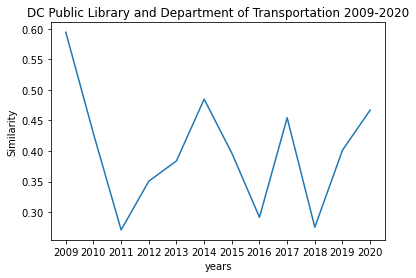

In [29]:
plt.plot(sim.keys(),sim.values())
plt.title("DC Public Library and Department of Transportation 2009-2020")
plt.ylabel("Similarity")
plt.xlabel("years")

To recommend business to vendors, we can get a list of existing partners(agencies that are already in contract with the vendor) and a list of potential candidates. Running such similarity analysis can help vendors to find out which candidate is more similar to which existing partners. 